# Pattern analysis
---

## Evaluation

We evalute the result of our method, *i.e. pattern summaries* according to the information they carry. For this purpose, we define 3 metrics: 
- *Diversity*: coverage of a large number of topics from the original graph is a great summarization quality 
- *Coverage*: we can hypothetize that a summary is more informative if it captures a large amount of entites from the original graph
- *Conciseness*: for human-readability as well as explainability, conciseness of the result is crucial 

**Diversity**: $Diversity(SG)=\dfrac{|\{(ps_i, ps_j), d(ps_i, ps_j) > \delta, \forall i \neq j, ps \in SG\}|}{|P|}$, with $P$ the list of all patterns, $SG$ a summarized graph and $ps$ a pattern summary. It number of distinct pairs of pattern summaries which exhibit a pairwise distance above a threshold. Distance $d$ can be evaluated using Wasserstein distance between pattern summary representations for example.

**Coverage**: $Coverage(SG)=\dfrac{|\{u, u \in SG\}|}{|\mathcal{V}|}$ is the proportion of nodes in the summary compared to the total number of nodes in the original graph.

**Conciseness**: $Conciseness(SG)= M(|\{u, u \in ps, \forall ps \in SG|\}) + M(|\{a, a \in ps, \forall ps \in SG|\})$, where $M$ denotes the median. A summary graph is concise if it contains few nodes and attributes, since it will be easier to interpret it. 

All together, we evalute a summary graph using the information $I$ it carries:
$$
I(SG) = \dfrac{Diversity(SG) \times Coverage(SG)}{Conciseness(SG)}
$$

In [11]:
from collections import defaultdict
from IPython.display import SVG
import numpy as np
import pickle
from scipy import sparse

from sknetwork.data import load_netset
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees
from sknetwork.visualization import svg_graph

In [131]:
def load_data(dataset):
    graph = load_netset(dataset)
    adjacency = graph.adjacency
    biadjacency = graph.biadjacency
    names = graph.names
    names_col = graph.names_col
    labels = graph.labels
    return adjacency, biadjacency, names, names_col, labels

def load_patterns(dataset, b, s, order):
    with open(f"../output/result/result_{dataset}_{b}_{s}_order{str(order)}.bin", "rb") as data:
        patterns = pickle.load(data)
    return patterns

def preprocess_data(biadjacency, names_col, s):
    # Frequent attributes
    freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

    # Filter data with index
    biadjacency = biadjacency[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Sort data
    sort_index = np.argsort(freq_attribute)
    sorted_biadjacency = biadjacency[:, sort_index]
    words = words[sort_index]
    return sorted_biadjacency, words

def get_pattern(patterns, i):
    return patterns[i][0], patterns[i][1]

def get_summarized_graph(adjacency, patterns):
    """Get summarized graph given patterns and original adjacency matrix."""
    
    rows, cols = [], []

    for p in patterns:

        # exclude first element of lattice 
        if len(p[1]) > 0:
            nodes = sorted(p[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_pattern = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_pattern.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_pattern.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def get_summarized_biadjacency(adjacency, biadjacency, patterns):
    summarized_biadj = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
    for p in patterns:
        if len(p[1]) > 0:
            for node in p[0]:
                summarized_biadj[node, p[1]] += 1

    summarized_biadj = sparse.csr_matrix(summarized_biadj.astype(bool), shape=summarized_biadj.shape)
    return summarized_biadj

def get_pattern_summaries(summarized_adjacency):
    # Summarized graph filtered on used nodes
    mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
    
    # Number of connected components (NOT considering isolated nodes)
    labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
    
    return labels_cc_summarized, mask    

def get_pw_distance_matrix(dataset, b, s, method='summaries'):
    with open(f'../output/result/wasserstein_distances_{dataset}_{b}_{s}_{method}.pkl', 'rb') as data:
        pw_distances = np.load(data)
    return pw_distances

def get_diversity(pw_distances, delta=0.2):
    n = pw_distances.shape[0]
    upper = pw_distances[np.triu_indices(n)]
    nb_ps = np.sum(upper > delta)
    return nb_ps / len(upper)

def get_coverage(summarized_adjacency):
    # number of nodes in summarized graph
    n_nodes = len(np.flatnonzero(summarized_adj.dot(np.ones(summarized_adj.shape[1]))))
    
    # Coverage
    cov = n_nodes / summarized_adjacency.shape[0]
    
    return cov

def get_conciseness(summarized_adjacency, summarized_biadjacency):
    n, m = summarized_biadjacency.shape
    
    out_deg_nodes = summarized_adj.dot(np.ones(n))
    nb_nodes_ps = np.median(out_deg_nodes[out_deg_nodes > 0])
    out_deg_attrs = summarized_biadjacency.dot(np.ones(m))
    nb_attrs_ps = np.median(out_deg_attrs[out_deg_attrs > 0])
    
    return np.median(nb_nodes_ps) + np.median(nb_attrs_ps)

def get_information_sg(summarized_adjacency, summarized_biadjacency, pw_distances):
    div = get_diversity(pw_distances)
    cov = get_coverage(summarized_adjacency)
    conc = get_conciseness(summarized_adjacency, summarized_biadjacency) 
    information = (div * cov) / conc
    print(f'inf: {information*100} - div: {div} - cov: {cov} - conc: {conc}')
    return information * 100

**Output evaluation**

In [132]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
betas = [8, 7, 6, 5]
ss = [8, 7, 6, 5]
with_order = [True]
delta = 0.2
informations = defaultdict()

for d, dataset in enumerate(datasets):
    informations[dataset] = defaultdict(list)
    # Load data
    adjacency, biadjacency, names, names_col, labels = load_data(dataset)
    print(f'Dataset: {dataset}...')
        
    for i, b in enumerate(betas):
        for k, s in enumerate(ss):
            
            new_biadjacency, words = preprocess_data(biadjacency, names_col, s)
            
            # Load patterns
            patterns = load_patterns(dataset, b, s, True)
            
            # Summarized graph + features
            summarized_adj = get_summarized_graph(adjacency, patterns)
            summarized_biadj = get_summarized_biadjacency(adjacency, new_biadjacency, patterns)
            
            # Pattern summaries
            pattern_summary_labels = get_pattern_summaries(summarized_adj)
            # Pattern summary pariwise distances
            pw_distances = get_pw_distance_matrix(dataset, b, s, method='summaries')
            
            # SG information
            information = get_information_sg(summarized_adj, summarized_biadj, pw_distances)
            informations[dataset][b].append(information)
        print('---')

Parsing files...
Done.
Dataset: wikivitals...
inf: 0.006151128495497059 - div: 0.3 - cov: 0.003895714713814804 - conc: 19.0
inf: 0.010936161815355993 - div: 0.48484848484848486 - cov: 0.006992308460693237 - conc: 31.0
inf: 0.01174383853436895 - div: 0.4264705882352941 - cov: 0.010188792328438718 - conc: 37.0
inf: 0.08294069800530342 - div: 0.6016806722689075 - cov: 0.020677255019478574 - conc: 15.0
---
inf: 0.0036626377651250296 - div: 0.2 - cov: 0.004395165318150035 - conc: 24.0
inf: 0.035569895671152714 - div: 0.7047619047619048 - cov: 0.00958945160323644 - conc: 19.0
inf: 0.025059347804328325 - div: 0.5584415584415584 - cov: 0.014583957646588753 - conc: 32.5
inf: 0.1159529039333329 - div: 0.601063829787234 - cov: 0.03086604734791729 - conc: 16.0
---
inf: 0.024166964725898285 - div: 0.5 - cov: 0.0074917590650284685 - conc: 15.5
inf: 0.05717395075942779 - div: 0.5526315789473685 - cov: 0.014484067525721706 - conc: 14.0
inf: 0.08612715651102457 - div: 0.6028225806451613 - cov: 0.023574

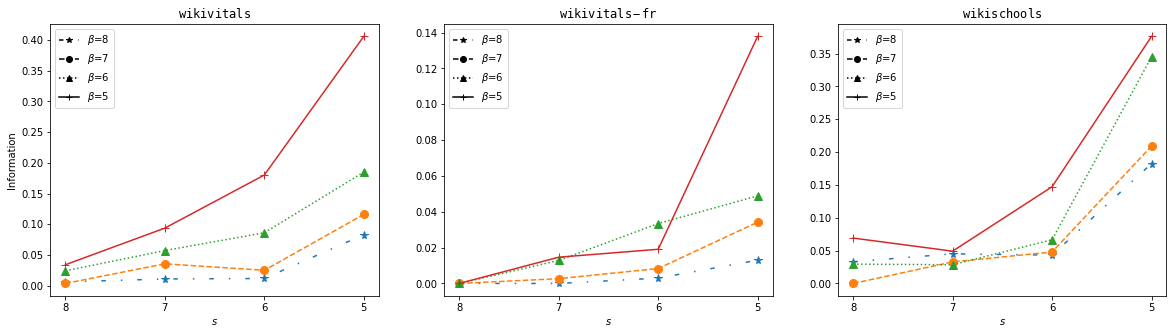

In [130]:
from matplotlib.lines import Line2D

markers = ['*', 'o', '^', '+']
styles = [(0, (3, 10, 1, 10)), 'dashed', 'dotted', 'solid']

fig, ax = plt.subplots(1, len(datasets), figsize=(20, 5))

legend_elements = [Line2D([0], [0], color='black', marker='*', linestyle=styles[0], label=r'$\beta$=8'),
                   Line2D([0], [0], color='black', marker='o', linestyle=styles[1], label=r'$\beta$=7'),
                   Line2D([0], [0], color='black', marker='^', linestyle=styles[2], label=r'$\beta$=6'),
                   Line2D([0], [0], color='black', marker='+', linestyle=styles[3], label=r'$\beta$=5'),
                   ]

for i, d in enumerate(datasets):
    for j, b in enumerate(betas):
        ax[i].plot(informations.get(d).get(b), marker=markers[j], linestyle=styles[j], markersize=8)
        ax[i].set_xticks(np.arange(0, len(ss)), labels=['8', '7', '6', '5'])
        ax[i].set_title(rf"$\tt{d}$")
        ax[i].set_xlabel(r'$s$')
        ax[i].legend(handles=legend_elements)
        if i == 0:
            ax[i].set_ylabel('Information')